# PySWMM - Python API to SWMM

This notebook demonstrates the basic capability provided by the PySWMM API to EPA SWMM. The basic example uses a simple tutorial model developed in PCSWMM, contained for present purposes in the `pcswmm_ex01/example01.inp` file. The PySWMM API can be used in conjuction with professional grade model development applications like PCSWMM to enable programmatic control of stormwater collection system models.

## Outline
The basic functionalities demonstrated in this notebook include programmatic manipulation of the previously created SWMM model to:

-  Read model output (from PCSWMM runs) in Jupyter
-  Write changes to model input files from Jupyter
-  Run the SWMM model programatically from Jupyter
-  Generate simple interactive graphics summarizing impacts of changes

### Read model output from prior runs

To access a SWMM outfile, you need to initialize a `pyswmm.output.Output` object. Once the `Output` object is initialized, you can use pre-defined methods to access data in the binary file.

In [1]:
from pyswmm import Output

First, just printing out the model features:

In [4]:
outpath = 'pcswmm_ex01/example1.out'

In [5]:
with Output(outpath) as out:
    print("Subcatchments: {}".format(len(out.subcatchments)))
    print("Nodes: {}".format(len(out.nodes)))
    print("Links: {}".format(len(out.links)))
    print("Version: {}".format(out.version))

Subcatchments: 1
Nodes: 2
Links: 1
Version: 51014


Members of each feature type are provided by calling the feature type:

In [6]:
out.nodes

{'J1': 0, 'OF1': 1}

In [7]:
out.links

{'C1': 0}

The next example opens the output and gets the entire depth timeseries for the outfall stored in the binary file using `pyswmm.output.Output.node_series` method.

In [8]:
from swmm.toolkit.shared_enum import NodeAttribute
from pyswmm import Output
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
with Output(outpath) as out:
    ts0 = pd.Series(out.node_series(
        'OF1',
        NodeAttribute.INVERT_DEPTH
    ))

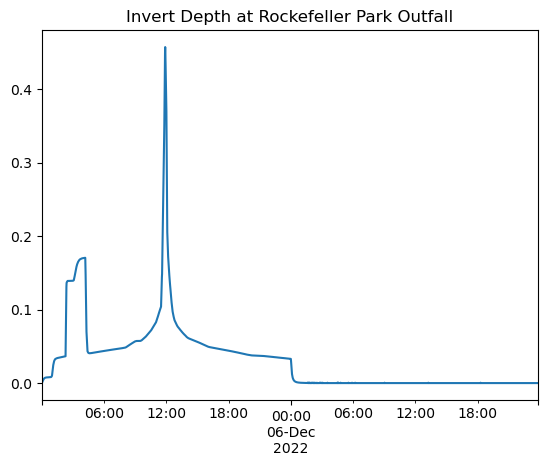

In [10]:
ts0.plot(title="Invert Depth at Rockefeller Park Outfall");

The above plot depicts the depth of flow at the catchment outfall upon completion of the getting started tutorial in PCSWMM. Next we can reach into the input file, change things up, then run the model again to compare results.

### Change rainfall data programmatically

Significant uncertainty in forecast rainfall can lead to uncertainty in utility performance. Simulating over weather forecasts in advance can help reduce, or at least better understand risks due to these uncertainties. 

Make a manual change to input file (renamed SCS storm to "Storm1" and changed some values...)

In [11]:
from pyswmm import Simulation, Subcatchments

In [13]:
inpath = 'pcswmm_ex01/example1.inp'
with Simulation(inpath) as sim:
    sim.execute()


... SWMM Version 5.1.14
... Run Complete

In [14]:
with Output(outpath) as out:
    ts0 = pd.Series(out.node_series(
        'OF1',
        NodeAttribute.INVERT_DEPTH
    ))

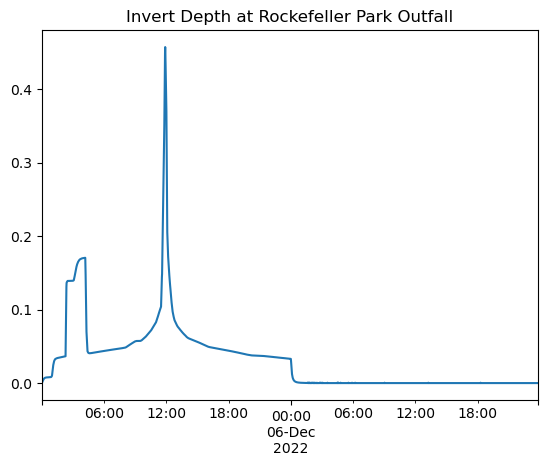

In [15]:
ts0.plot(title="Invert Depth at Rockefeller Park Outfall");

Now to do this programmatically, we need to import the raingauge timeseries and alter it from Python:

In [16]:
import swmmio

In [17]:
rainfall = swmmio.utils.dataframes.dataframe_from_inp(inpath, section='TIMESERIES')

In [18]:
rainfall

,Date,Time,Value
Name,,,
SCS_Type_II_5in,12/05/2022,00:00:00,0.0505
SCS_Type_II_5in,12/05/2022,00:06:00,0.0505
SCS_Type_II_5in,12/05/2022,00:12:00,0.0515
SCS_Type_II_5in,12/05/2022,00:18:00,0.0515
SCS_Type_II_5in,12/05/2022,00:24:00,0.0525
...,...,...,...
SCS_Type_II_5in,12/05/2022,23:30:00,0.0560
SCS_Type_II_5in,12/05/2022,23:36:00,0.0560
SCS_Type_II_5in,12/05/2022,23:42:00,0.0555


In [19]:
rainfall['Value'].values

array([0.0505, 0.0505, 0.0515, 0.0515, 0.0525, 0.0525, 0.0535, 0.0535,
       0.0545, 0.0545, 0.0555, 0.0555, 0.0565, 0.0565, 0.0575, 0.0575,
       0.0585, 0.0585, 0.0595, 0.0595, 0.0605, 0.0605, 0.0615, 1.0615,
       1.0625, 1.0625, 1.0635, 1.0635, 1.0645, 1.0645, 1.0655, 1.0655,
       1.0665, 1.0665, 1.0675, 1.0675, 1.0685, 1.0685, 1.0695, 1.0695,
       1.0705, 1.0715, 0.0725, 0.0735, 0.0745, 0.0755, 0.0765, 0.0775,
       0.0785, 0.0795, 0.0805, 0.0815, 0.0825, 0.0835, 0.0845, 0.0855,
       0.0865, 0.0875, 0.0885, 0.0895, 0.0905, 0.0915, 0.0925, 0.0935,
       0.0945, 0.0955, 0.0965, 0.0975, 0.0985, 0.0995, 0.1005, 0.1015,
       0.1025, 0.1035, 0.1045, 0.1055, 0.1065, 0.1075, 0.1085, 0.1095,
       0.1125, 0.1175, 0.1225, 0.1275, 0.1325, 0.1375, 0.1425, 0.1475,
       0.1525, 0.1575, 0.16  , 0.16  , 0.16  , 0.16  , 0.16  , 0.164 ,
       0.172 , 0.18  , 0.188 , 0.196 , 0.206 , 0.218 , 0.23  , 0.242 ,
       0.254 , 0.27  , 0.29  , 0.31  , 0.33  , 0.35  , 0.384 , 0.432 ,
      

Alter the series here with some random perturbations:

In [20]:
import random
import numpy as np

In [21]:
new_rain = np.array([random.gauss(i, sigma=0.1) for i in rainfall['Value'].values])

In [22]:
rainfall['Value'] = new_rain

In [23]:
rainfall['Value']

Name
SCS_Type_II_5in    0.233562
SCS_Type_II_5in   -0.086479
SCS_Type_II_5in    0.165701
SCS_Type_II_5in    0.056293
SCS_Type_II_5in    0.073520
                     ...   
SCS_Type_II_5in    0.154013
SCS_Type_II_5in    0.079099
SCS_Type_II_5in    0.163787
SCS_Type_II_5in    0.060362
SCS_Type_II_5in    0.181307
Name: Value, Length: 240, dtype: float64

Now just neet to write these changes back to the input file:

In [24]:
import os
import swmmio

In [25]:
baseline = swmmio.Model(inpath)
baseline.inp.timeseries.Value = new_rain
baseline.inp.save('pcswmm_ex01/example03.inp')

Now run the model again:

In [26]:
inpath = 'pcswmm_ex01/example03.inp'
with Simulation(inpath) as sim:
    sim.execute()


... SWMM Version 5.1.14
... Run Complete

In [27]:
with Output('pcswmm_ex01/example03.out') as out:
    ts1 = pd.Series(out.node_series(
        'OF1',
        NodeAttribute.INVERT_DEPTH
    ))

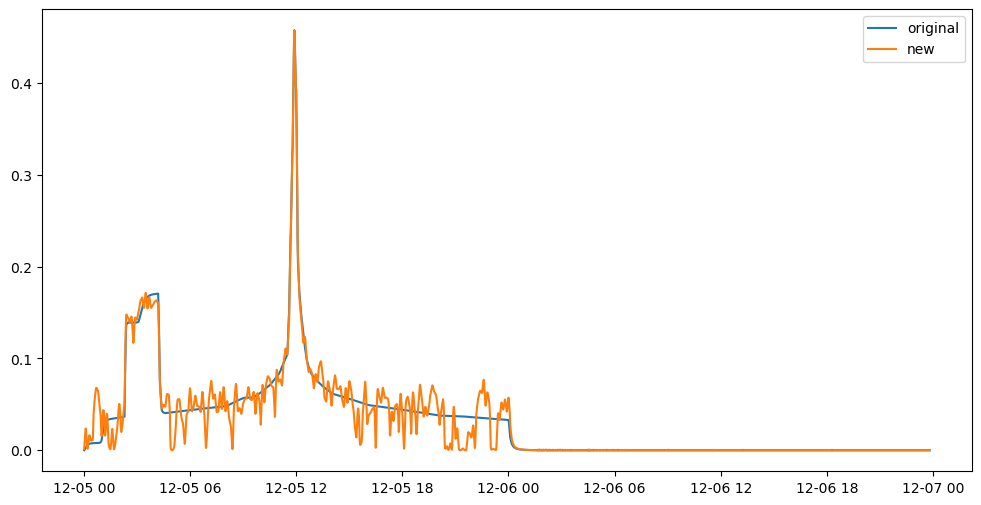

In [28]:
plt.figure(figsize=(12,6))
plt.plot(ts0.index, ts0.values, label='original')
plt.plot(ts1.index, ts1.values, label='new')
plt.legend();

### Generate simple interactive graphics comparing simulations

The capabilities demonstrated above can be tied into a visualization package (Dash) built for data scientists to quickly generate interactive dashboards with complex callback functionality. A simple example is provided here using the `jupyter-dash` library, which extends Dash to serve apps within the Jupyter notebook.

In [26]:
from dash import dcc

In [27]:
import plotly.graph_objects as go 
import numpy as np

In [28]:
def go_line(ts0, ts1):
    # Create traces
    fig = go.Figure()
    fig.add_trace(go.Line(x=ts0.index,y=ts0.values,
                        mode='lines',
                        name='original'))
    fig.add_trace(go.Line(x=ts1.index,y=ts1.values,
                        mode='lines',
                        name='new'))
    fig.show()

In [29]:
go_line(ts0, ts1)

c:\Users\gcoyle\Anaconda3\envs\pyswmm39\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [30]:
# # -*- coding: utf-8 -*-
# from jupyter_dash import JupyterDash
# from dash import dcc, html
# from dash.dependencies import Input, Output, State

# external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

# app = JupyterDash(__name__)

# app.layout = html.Div([
#     dcc.Input(id='input-1-state', type='text', value='Montréal'),
#     dcc.Input(id='input-2-state', type='text', value='Canada'),
#     html.Button(id='submit-button-state', n_clicks=0, children='Submit'),
#     html.Div(id='output-state')
# ])


# @app.callback(Output('output-state', 'children'),
#               Input('submit-button-state', 'n_clicks'),
#               State('input-1-state', 'value'),
#               State('input-2-state', 'value'))
# def update_output(n_clicks, input1, input2):
#     return u'''
#         The Button has been pressed {} times,
#         Input 1 is "{}",
#         and Input 2 is "{}"
#     '''.format(n_clicks, input1, input2)

# # Run app and display result inline in the notebook
# app.run_server(mode='inline')
# # if __name__ == '__main__':
# #     app.run_server(debug=True)

In [31]:
# # -*- coding: utf-8 -*-
# from jupyter_dash import JupyterDash
# from dash import dcc, html
# from dash.dependencies import Input, Output, State

# external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

# app = JupyterDash(__name__)

# app.layout = html.Div([
#     dcc.Input(id='input-1-state', type='text', value='Montréal'),
#     dcc.Input(id='input-2-state', type='text', value='Canada'),
#     html.Button(id='submit-button-state', n_clicks=0, children='Submit'),
#     html.Div(id='output-state')
# ])


# @app.callback(Output('output-state', 'children'),
#               Input('submit-button-state', 'n_clicks'),
#               State('input-1-state', 'value'),
#               State('input-2-state', 'value'))
# def update_output(n_clicks, input1, input2):
#     return u'''
#         The Button has been pressed {} times,
#         Input 1 is "{}",
#         and Input 2 is "{}"
#     '''.format(n_clicks, input1, input2)

# # Run app and display result inline in the notebook
# app.run_server(mode='inline')
# # if __name__ == '__main__':
# #     app.run_server(debug=True)

In [32]:
# import plotly.express as px
# from jupyter_dash import JupyterDash
# from dash import dcc
# from dash import html
# from dash.dependencies import Input, Output
# # Load Data
# df = px.data.tips()
# # Build App
# app = JupyterDash(__name__)
# app.layout = html.Div([
#     html.H1("SWMM Model Updating"),
#     dcc.Graph(id='graph'),
#     html.Label([
#         "colorscale",
#         dcc.Dropdown(
#             id='colorscale-dropdown', clearable=False,
#             value='plasma', options=[
#                 {'label': c, 'value': c}
#                 for c in px.colors.named_colorscales()
#             ])
#     ]),
#     html.Button(id='reset-button', n_clicks=0, children='Reset')
# ])

# # Define callback to update graph
# @app.callback(
#     Output('graph', 'figure'),
#     [Input("colorscale-dropdown", "value")]
# )
# def update_figure(colorscale):
#     return px.scatter(
#         df, x="total_bill", y="tip", color="size",
#         color_continuous_scale=colorscale,
#         render_mode="webgl", title="Tips"
#     )

# @app.callback(
#     Output('graph','figure'),
#     Input('reset-button','n_clicks')
# )
# def reset_figure(value='plasma'):
#     return update_figure(value)

# # Run app and display result inline in the notebook
# app.run_server(mode='inline')

In [31]:
# def make_rain(inpath, file_cnt):
#     # get current model rainfall
#     baseline = swmmio.Model(inpath)
#     rain = baseline.inp.timeseries.Value.values
#     # induce noise
#     new_rain = np.array([random.lognormvariate(float(i), sigma=0.1) for i in rain])
#     baseline.inp.timeseries.Value = new_rain
#     # save back to new model input file
#     basepath = 'pcswmm_ex01/example'
#     filext = '.inp'
#     newfp = basepath + str(file_cnt) + filext
#     baseline.inp.save(newfp)
#     return newfp

In [33]:
inpath = 'pcswmm_ex01/example01.inp'

In [34]:
import pandas as pd

In [35]:
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
# Load Data
# df = px.data.tips()
# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("SWMM Model Updating"),
    dcc.Graph(id='graph'),
    html.Button(id='rain-button', n_clicks=0, children='Random')
])
    
# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    Input('rain-button','n_clicks')
)
def make_rain(inpath='pcswmm_ex01/example01.inp', file_cnt=5):
    # get current model rainfall
    baseline = swmmio.Model(inpath)
    rain = baseline.inp.timeseries.Value.values
    # induce noise
    new_rain = np.array([random.lognormvariate(float(i), sigma=0.1) for i in rain])
    baseline.inp.timeseries.Value = new_rain
    # save back to new model input file
    basepath = 'pcswmm_ex01/example'
    filext = '.inp'
    newfp = basepath + str(file_cnt) + filext
    baseline.inp.save(newfp)
    return update_figure(newfp)

def update_figure(newfp):
    # read original model output
    with Output('pcswmm_ex01/example01.out') as out:
        ts0 = pd.Series(out.node_series(
            'OF1',
            NodeAttribute.INVERT_DEPTH
        ))

    # read new model output
    with Output(newfp) as out:
        ts1 = pd.Series(out.node_series(
            'OF1',
            NodeAttribute.INVERT_DEPTH
        ))

    # Create traces
    fig = go.Figure()
    fig.add_trace(go.Line(x=ts0.index,y=ts0.values,
                        mode='lines',
                        name='original'))
    fig.add_trace(go.Line(x=ts1.index,y=ts1.values,
                        mode='lines',
                        name='new'))
    fig.update_layout(transition_duration=500)
    return fig

# Run app and display result inline in the notebook
app.run_server(mode='inline')

In [14]:
from pyswmm import Simulation, Subcatchments

The `Simulation` module allows running a model, given an input file:

In [42]:
inpath = 'pcswmm_ex01/example01.inp'
with Simulation(inpath) as sim:
    sim.execute()


... SWMM Version 5.1.14
... Run Complete

While the `Subcatchments` module allows interaction with the subcatchments described in a model.

In [60]:
# modify subcatchment attributes and run model
with Simulation(inpath, ) as sim:
    s1 = Subcatchments(sim)['S1']
    print("S1 slope is {}".format(s1.slope))
    s1.slope = 120
    print("S1 slope changed to {}".format(s1.slope))
    sim.execute()

# read new output into Series
with Output(outpath) as out:
    ts1 = pd.Series(out.node_series(
        'OF1',
        NodeAttribute.INVERT_DEPTH
    ))

S1 slope is 0.005
S1 slope changed to 120.0

... SWMM Version 5.1.14
... Run Complete

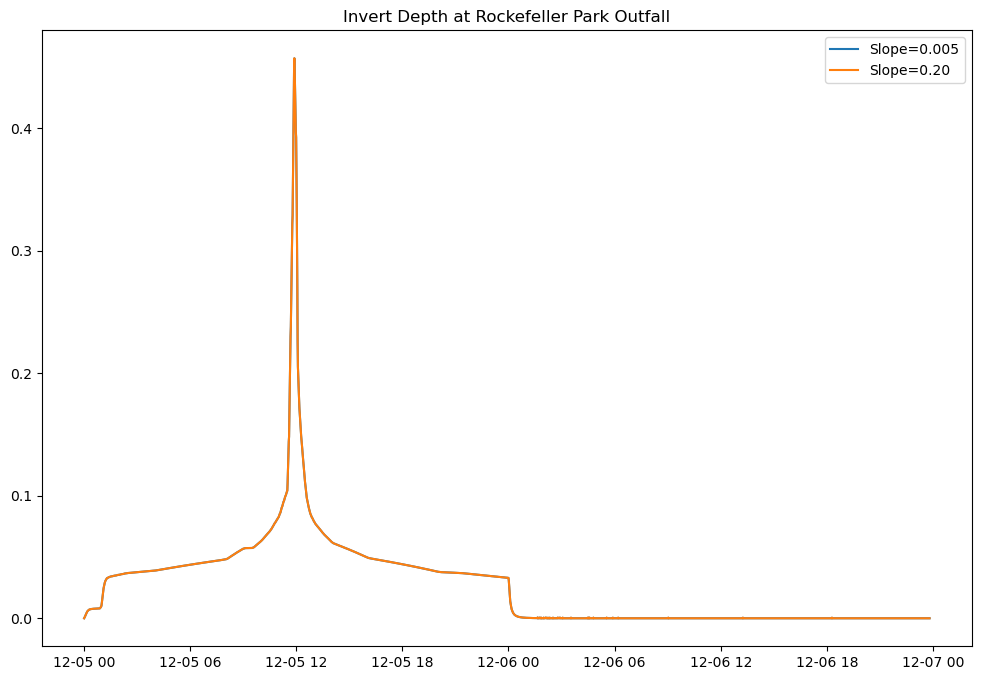

In [61]:
plt.figure(figsize=(12,8))
plt.plot(ts0.index, ts0.values, label="Slope=0.005")
plt.plot(ts1.index, ts1.values, label="Slope=0.20")
plt.title("Invert Depth at Rockefeller Park Outfall")
plt.legend();

That's clearly not working... try it with changing pipe parameters (roughness) instead... why? The issue is not with the sensitivity of the model to slope, it's that the output is not being updated by the simulator, right? Wrong - the output file is being overwritten everytime `sim.execute()` is called. So why am I not getting any changes?

In [62]:
from pyswmm import Simulation, Links

The `Simulation` module allows running a model, given an input file:

In [63]:
inpath = 'pcswmm_ex01/example01.inp'
with Simulation(inpath) as sim:
    sim.execute()


... SWMM Version 5.1.14
... Run Complete

While the `Subcatchments` module allows interaction with the subcatchments described in a model.

In [66]:
# modify subcatchment attributes and run model
with Simulation(inpath) as sim:
    c1 = Links(sim)['C1']
    print("C1 outlet headloss is {}".format(c1.connections))
    # s1.slope = 0.800
    # print("S1 impervious area changed to {}".format(s1.slope))
    # sim.execute()

# read new output into Series
# with Output(outpath) as out:
#     ts1 = pd.Series(out.node_series(
#         'OF1',
#         NodeAttribute.INVERT_DEPTH
#     ))

C1 outlet headloss is ('J1', 'OF1')


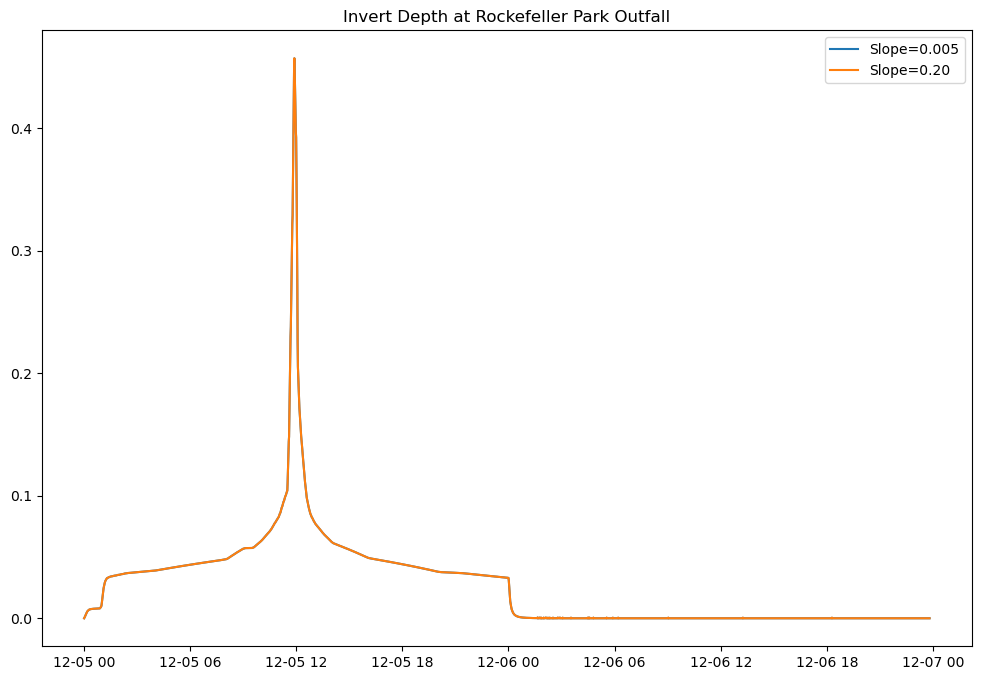

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(ts0.index, ts0.values, label="Slope=0.005")
plt.plot(ts1.index, ts1.values, label="Slope=0.20")
plt.title("Invert Depth at Rockefeller Park Outfall")
plt.legend();